In [1]:
import torch.nn as nn
import numpy as np
import gym
from seagul.rl.ars.meta_ars import MetaARSAgent
import matplotlib.pyplot as plt
import torch
import dill
import seagul.envs
import pybullet_envs

import os
os.getcwd()

/home/sgillen/work/seagul/seagul/envs/__init__.py:56: UserWarning: Warning, pybullet envs not installed
  warnings.warn("Warning, pybullet envs not installed")


'/home/sgillen/work/switching_control/src'

In [ ]:
slope_set = [0.01]
meta_agent = MetaARSAgent("hmap_hopper-v0", n_agents=8, n_top_agents=4, epochs_per_meta_update=200, 
                          kwargs={"n_workers" : 24, "step_size": .05, "exp_noise": .05, "env_config": {"slope_set":slope_set}})

import time
start = time.time()
meta_agent.learn(1, verbose=False)
print(time.time() - start)

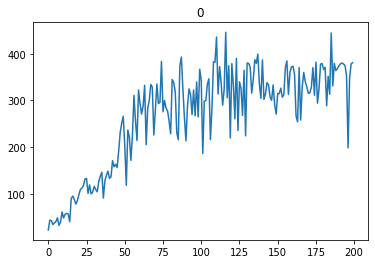

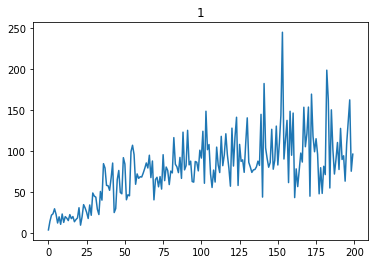

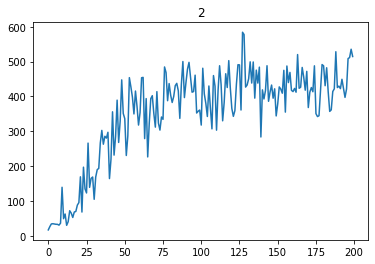

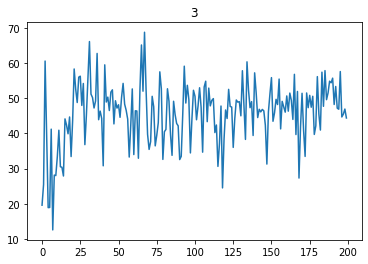

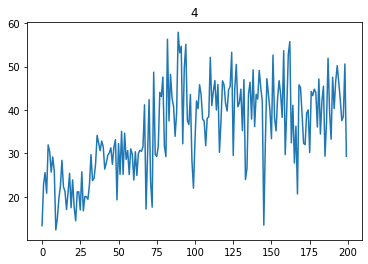

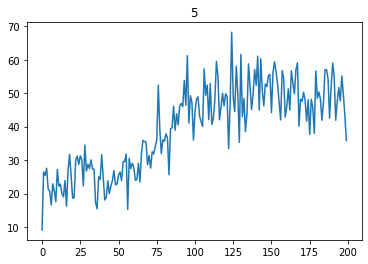

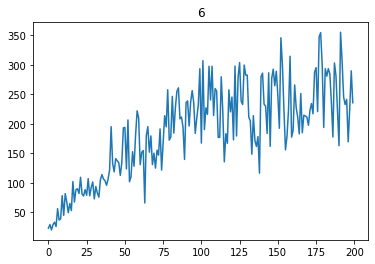

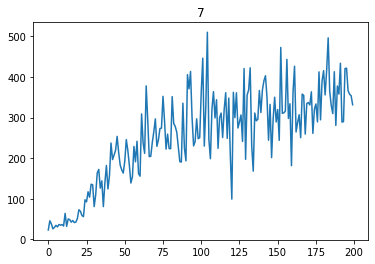

<Figure size 432x288 with 0 Axes>

In [3]:
for i in range(len(meta_agent.agents)):
    plt.plot(meta_agent.agents[i].lr_hist)
    plt.title(str(i))
    plt.figure()

In [9]:
# import pickle
# with open("../switching_control/src/meta_hmap_hopper_obs", "wb") as f:
#     pickle.dump(meta_agent, f)

In [10]:
import pickle
meta_agent = pickle.load(open("meta_hmap_hopper_obs", "rb"))

In [4]:
meta_agent.agents[1].state_mean

array([ 1.39034298, -0.07168315, -0.06111436, -0.41272839,  0.41871085,
        0.11646272, -0.43512861, -0.01523   , -0.01357308, -0.10884714,
        0.06398123,  3.25547236,  3.25547236])

In [5]:
meta_agent.env_name

'hmap_hopper-v0'

In [6]:
agent = meta_agent.agents[4]

In [7]:
import time
# Rollout Fns ==================================================
def do_rollout(env, policy, render=False, ep_length=1000, return_on_done=False):
    act_list = []
    obs_list = []
    rew_list = []
    done_list = []

    obs = env.reset()
    done = False
    cur_step = 0
    

    while cur_step < ep_length:
        obs_list.append(np.copy(obs))
        act,_,_,_ = policy.step(obs)
        obs, rew, done, _ = env.step(act)
        if render:
            env.render()
            time.sleep(.01)
            
        if done and return_on_done:
            break
            
#         ncon = env.unwrapped.sim.data.ncon
#         if ncon:
#             print("ncon: ", ncon)
#             for i in range(ncon):
#                 print(env.unwrapped.sim.data.contact[i].geom1, env.unwrapped.sim.data.contact[i].geom2)
#             print()
            

        act_list.append(np.copy(act))
        rew_list.append(rew)
        done_list.append(done)

        cur_step += 1

    ep_obs = np.stack(obs_list)
    ep_act = np.stack(act_list)
    ep_rew = np.array(rew_list)
    ep_rew = ep_rew.reshape(-1, 1)
    ep_done = np.array(done_list)

    return ep_obs, ep_act, ep_rew, ep_done


env_name = "hmap_hopper-v0"
seed = 4
env = gym.make(env_name, slope_set = slope_set)
#env = gym.make("Hopper-v2")

#agent = meta_agent.agents[seed]
obs, act, rew, _ = do_rollout(env, agent.model, render=True, ep_length=1000, return_on_done=True)
print(sum(rew))

TypeError: __init__() got an unexpected keyword argument 'random'

In [ ]:
plt.plot(obs);

In [ ]:
n_steps = 500
step_length = 500//n_steps
step_incr = 1/n_steps
ncol = 1000
cur_x = 200
cur_height = 0
env.model.hfield_data[:] = 0

for step in range(n_steps-1):
    cur_height += step_incr
    cur_x += step_length 
    env.model.hfield_data[cur_x:cur_x+step_length] = cur_height
    env.model.hfield_data[ncol+cur_x:ncol+cur_x+step_length] = cur_height
    
env.model.hfield_data[cur_x+step_length:ncol] = 1
env.model.hfield_data[ncol+cur_x+step_length:] = 1
agent = meta_agent.agents[seed]
obs, act, rew, _ = do_rollout(env, agent.model, render=True, ep_length=10000)
print(sum(rew))

plt.plot(obs)

In [ ]:
env.reset()
env.viewer_setup()
while True:
    env.render()
    time.sleep(.01)

In [17]:
import copy
old_agent = copy.deepcopy(agent)
agent.learn(100);

0 : mean return: 1693.3122523884585, fps:38634.68947483134
1 : mean return: 2025.9789265653121, fps:37565.391532095135
2 : mean return: 2395.523515450288, fps:41706.65206009198
3 : mean return: 2613.1454892296088, fps:41181.90757807416
4 : mean return: 2809.219954058968, fps:43033.32488358616
5 : mean return: 2888.1029116135155, fps:43613.048139943436
6 : mean return: 3013.791138095656, fps:47925.60163048034
7 : mean return: 3013.6615283460515, fps:45359.35471686006
8 : mean return: 3067.8615925361146, fps:46823.00325640479
9 : mean return: 3073.661141909779, fps:46718.93062958619
10 : mean return: 3165.3069247560115, fps:46889.830462131846
11 : mean return: 3067.3047731493475, fps:45393.80395691888
12 : mean return: 3148.5699036964825, fps:46736.92045242559
13 : mean return: 3132.932857138086, fps:45682.690079697866
14 : mean return: 3182.206710808823, fps:45960.54317985396
15 : mean return: 3182.7818955386465, fps:46283.257949342056
16 : mean return: 3123.164990792793, fps:43808.6344

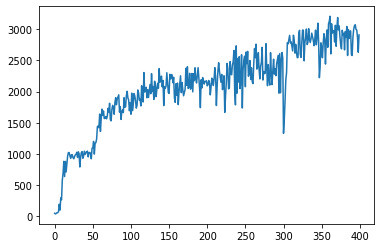

In [18]:
plt.plot(agent.lr_hist)

In [ ]:


n_steps = 50
step_length = 100
step_incr = 1/n_steps
ncol = 1000
cur_x = 100*(1000//400)
cur_height = 0
env.model.hfield_data[:] = 0

for step in range(n_steps-1):
    cur_height += step_incr
    cur_x += step_length 
    env.model.hfield_data[cur_x:cur_x+step_length] = cur_height
    env.model.hfield_data[ncol+cur_x:ncol+cur_x+step_length] = cur_height

env.model.hfield_data[cur_x+step_length:ncol] = 1
env.model.hfield_data[ncol+cur_x+step_length:] = 1


In [22]:
env.reset()
env.render()
env.viewer_setup()

while True:
    env.render()
    time.sleep(.01)

KeyboardInterrupt: 

In [3]:
slope = .05
ramp_length = int(1//slope)

ncol = 1000
cur_x = 100*(1000//400)
cur_height = 0
env.model.hfield_data[:] = 0

for step in range(ramp_length):
    cur_height += slope
    cur_x += 1 
    env.model.hfield_data[cur_x] = cur_height
    env.model.hfield_data[ncol+cur_x] = cur_height

env.model.hfield_data[cur_x:ncol] = 1
env.model.hfield_data[ncol+cur_x:] = 1

NameError: name 'env' is not defined

In [4]:
env.reset()
env.render()
env.viewer_setup()

while True:
    env.render()
    time.sleep(.01)

NameError: name 'env' is not defined

In [43]:
ramp_length

199

In [44]:
cur_height

0.9950000000000008

In [53]:
env.model.hfield_data[:1000]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.